#Topik : Segmentasi Pelanggan Berdasarkan Perilaku Transaksi dan Preferensi Produk  
####Untuk mengelompokkan pelanggan ke dalam segmen (misal: “pembeli impulsif”, “pembeli rutin”, “pembeli diskonan”) berdasarkan frekuensi pembelian, kategori produk, jumlah pembelian, nilai transaksi.

Tabel digunakan: orders, order_items, product, customer

Algoritma: Clustering (K-Means)





In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA # Import PCA


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#DATA WRAGLING

## 1. Tabel Order

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/KULIAH/SEMESTER 4/ML/E-Commerce Public Dataset/orders_dataset.csv')
data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [ ]:
data.info()
print(data['order_id'].dtype)
print(data.dtypes.unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB
object
[dtype('O')]


In [ ]:
print("Total Baris = ",data.shape[0])
print("Total Kolom = ",data.shape[1])

Total Baris =  99441
Total Kolom =  8


###lihat missing value

In [ ]:
data.isnull().sum()

,0
order_id,0
customer_id,0
order_status,0
order_purchase_timestamp,0
order_approved_at,160
order_delivered_carrier_date,1783
order_delivered_customer_date,2965
order_estimated_delivery_date,0


In [ ]:
non_delivered = data[data['order_status']!='delivered'].shape[0]
print(non_delivered if non_delivered > 0 else 0)

2963


Jumlah order_status != delivered = 2963
Ini hampir sama dengan jumlah missing di order_delivered_customer_date (2965)

INSIGHT :
Artinya sebagian besar data yang missing di kolom pengiriman memang belum dikirim, alias statusnya bukan delivered. So, mereka valid tapi tidak relevan buat analisis behavior pasca-transaksi

Keputusan : DROP AJA





In [ ]:
data = data.dropna(subset=[
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date'
])

In [ ]:
data.reset_index(drop=True, inplace=True)

In [ ]:
data.shape

(96461, 8)

###lihat duplicate value

In [ ]:
data.duplicated().sum()

np.int64(0)

###memastikan timestamp

In [ ]:
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])

###cek outlier

In [ ]:
mask = data['order_delivered_customer_date'] < data['order_purchase_timestamp']
data[mask]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date


###cek order yg cansel

In [ ]:
data['order_status'].value_counts()

,count
order_status,
delivered,96455
canceled,6


###Final data after wragling


In [ ]:
orders = data[data['order_status'] == 'delivered']

In [ ]:
orders.shape

(96455, 8)

## 2. Tabel Order Item

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/KULIAH/SEMESTER 4/ML/E-Commerce Public Dataset/order_items_dataset.csv')
data.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [ ]:
data.info()
print(data['order_id'].dtype)
print(data.dtypes.unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB
object
[dtype('O') dtype('int64') dtype('float64')]


In [ ]:
print("Total Baris = ",data.shape[0])
print("Total Kolom = ",data.shape[1])

Total Baris =  112650
Total Kolom =  7


###cek missing value

In [ ]:
data.isnull().sum()

,0
order_id,0
order_item_id,0
product_id,0
seller_id,0
shipping_limit_date,0
price,0
freight_value,0


###cek duplikat

In [ ]:
data.duplicated().sum()

np.int64(0)

###merubah waktu ke datetime

In [ ]:
data['shipping_limit_date'] = pd.to_datetime(data['shipping_limit_date'])

###Final data after wragling

In [ ]:
ordersitem = data
ordersitem.shape

(112650, 7)

##3. Tabel Produk

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/KULIAH/SEMESTER 4/ML/E-Commerce Public Dataset/products_dataset.csv')
data.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [ ]:
data.info()
print(data['product_id'].dtype)
print(data.dtypes.unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB
object
[dtype('O') dtype('float64')]


In [ ]:
print("Total Baris = ",data.shape[0])
print("Total Kolom = ",data.shape[1])

Total Baris =  32951
Total Kolom =  9


###cek missing value

In [ ]:
data.isnull().sum()

,0
product_id,0
product_category_name,610
product_name_lenght,610
product_description_lenght,610
product_photos_qty,610
product_weight_g,2
product_length_cm,2
product_height_cm,2
product_width_cm,2


In [ ]:
data['product_category_name']= data['product_category_name'].fillna('Uncategorized')

In [ ]:
data['product_name_lenght'] = data['product_name_lenght'].fillna(data['product_name_lenght'].median())
data['product_description_lenght'] = data['product_description_lenght'].fillna(data['product_description_lenght'].median())
data['product_photos_qty'] = data['product_photos_qty'].fillna(data['product_photos_qty'].median())
data['product_weight_g'] = data['product_weight_g'].fillna(data['product_weight_g'].median())
data['product_length_cm'] = data['product_length_cm'].fillna(data['product_length_cm'].median())
data['product_height_cm'] = data['product_height_cm'].fillna(data['product_height_cm'].median())
data['product_width_cm'] = data['product_width_cm'].fillna(data['product_width_cm'].median())

In [ ]:
data.isnull().sum()

,0
product_id,0
product_category_name,0
product_name_lenght,0
product_description_lenght,0
product_photos_qty,0
product_weight_g,0
product_length_cm,0
product_height_cm,0
product_width_cm,0


###cek data duplikat

In [ ]:
data.duplicated().sum()

np.int64(0)

###ubah dimensi ke volume

In [ ]:
data['product_volume_cm3'] = data['product_length_cm'] * data['product_height_cm'] * data['product_width_cm']

###pilih kolom yg relevan aja


In [ ]:
selected_cols = [
    'product_id',
    'product_category_name',
    'product_photos_qty',
    'product_name_lenght',
    'product_description_lenght',
    'product_weight_g',
    'product_volume_cm3'
]
products = data[selected_cols]


###Final data after wragling

In [ ]:
products.shape

(32951, 7)

## 4. Tabel Customer

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/KULIAH/SEMESTER 4/ML/E-Commerce Public Dataset/customers_dataset.csv')
data.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [ ]:
data.info()
print(data['customer_id'].dtype)
print(data.dtypes.unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
object
[dtype('O') dtype('int64')]


In [ ]:
print("Total Baris = ",data.shape[0])
print("Total Kolom = ",data.shape[1])

Total Baris =  99441
Total Kolom =  5


###cek missing value

In [ ]:
data.isnull().sum()

,0
customer_id,0
customer_unique_id,0
customer_zip_code_prefix,0
customer_city,0
customer_state,0


### cek duplikat id customer

In [ ]:
data.duplicated(subset='customer_id').sum()

np.int64(0)

###Final data after wragling

In [ ]:
customers = data
customers.shape

(99441, 5)

#FEATURE ENGINEERING

##Data merging

In [ ]:
# Merge 1: orders + ordersitem (based on 'order_id')
df_merge = pd.merge(orders, ordersitem, on='order_id', how='inner')

# Merge 2: + products (based on 'product_id')
df_merge = pd.merge(df_merge, products, on='product_id', how='inner')

# Merge 3: + customers (based on 'customer_id')
data_merge = pd.merge(df_merge, customers, on='customer_id', how='inner')

In [ ]:
data_merge.shape

(110173, 24)

In [ ]:
data_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110173 entries, 0 to 110172
Data columns (total 24 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       110173 non-null  object        
 1   customer_id                    110173 non-null  object        
 2   order_status                   110173 non-null  object        
 3   order_purchase_timestamp       110173 non-null  datetime64[ns]
 4   order_approved_at              110173 non-null  object        
 5   order_delivered_carrier_date   110173 non-null  object        
 6   order_delivered_customer_date  110173 non-null  object        
 7   order_estimated_delivery_date  110173 non-null  object        
 8   order_item_id                  110173 non-null  int64         
 9   product_id                     110173 non-null  object        
 10  seller_id                      110173 non-null  object        
 11  

In [ ]:
data_merge.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_category_name,product_photos_qty,product_name_lenght,product_description_lenght,product_weight_g,product_volume_cm3,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,...,utilidades_domesticas,4.0,40.0,268.0,500.0,1976.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1,595fac2a385ac33a80bd5114aec74eb8,...,perfumaria,1.0,29.0,178.0,400.0,4693.0,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1,aa4383b373c6aca5d8797843e5594415,...,automotivo,1.0,46.0,232.0,420.0,9576.0,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,1,d0b61bfb1de832b15ba9d266ca96e5b0,...,pet_shop,3.0,59.0,468.0,450.0,6000.0,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,1,65266b2da20d04dbe00c5c2d3bb7859e,...,papelaria,4.0,38.0,316.0,250.0,11475.0,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


##Eliminasi Fitur
Mengeliminasi fitur-fitur yang redundant atau tidak memberikan kontribusi signifikan terhadap segmentasi pelanggan.

In [ ]:
columns_to_drop = [
    'order_status', 'order_approved_at', 'order_delivered_carrier_date', 'order_estimated_delivery_date',
    'seller_id', 'shipping_limit_date', 'product_photos_qty', 'product_name_lenght',
    'product_description_lenght', 'product_weight_g', 'customer_unique_id',
    'customer_zip_code_prefix', 'customer_city', 'customer_state'
]
df_clean = data_merge.drop(columns=columns_to_drop)
df_clean.shape
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110173 entries, 0 to 110172
Data columns (total 10 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       110173 non-null  object        
 1   customer_id                    110173 non-null  object        
 2   order_purchase_timestamp       110173 non-null  datetime64[ns]
 3   order_delivered_customer_date  110173 non-null  object        
 4   order_item_id                  110173 non-null  int64         
 5   product_id                     110173 non-null  object        
 6   price                          110173 non-null  float64       
 7   freight_value                  110173 non-null  float64       
 8   product_category_name          110173 non-null  object        
 9   product_volume_cm3             110173 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(5)
memory usage: 

In [ ]:
df_clean.columns

Index(['order_id', 'customer_id', 'order_purchase_timestamp',
       'order_delivered_customer_date', 'order_item_id', 'product_id', 'price',
       'freight_value', 'product_category_name', 'product_volume_cm3'],
      dtype='object')

In [ ]:
data_merge.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_category_name,product_photos_qty,product_name_lenght,product_description_lenght,product_weight_g,product_volume_cm3,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,...,utilidades_domesticas,4.0,40.0,268.0,500.0,1976.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1,595fac2a385ac33a80bd5114aec74eb8,...,perfumaria,1.0,29.0,178.0,400.0,4693.0,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1,aa4383b373c6aca5d8797843e5594415,...,automotivo,1.0,46.0,232.0,420.0,9576.0,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,1,d0b61bfb1de832b15ba9d266ca96e5b0,...,pet_shop,3.0,59.0,468.0,450.0,6000.0,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,1,65266b2da20d04dbe00c5c2d3bb7859e,...,papelaria,4.0,38.0,316.0,250.0,11475.0,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


## Aggregasi Fitur
Meringkas data transaksi jadi insight perilaku per pelanggan.

Alias:🔁 Mengubah data level transaksi → menjadi data level pelanggan.

Kenapa Ini Penting Sebelum Clustering:
Karena model K-Means cuma bisa bekerja kalau setiap baris adalah 1 objek yang ingin diklasifikasikan (dalam hal ini: 1 customer), dan setiap kolom adalah fitur numerik yang bisa dihitung jaraknya.

So…

Step aggregasi = meringkas semua perilaku tiap customer

In [ ]:
# Pastikan data sudah dalam df_clean
df = df_clean.copy()

# Agregasi data per customer_id
agg_data = df.groupby('customer_id').agg(
    num_orders=('order_id', pd.Series.nunique),
    num_items=('order_item_id', 'sum'),
    total_spent=('price', 'sum'),
    avg_spent_per_order=('price', lambda x: x.sum() / x.nunique()),
    avg_freight_value=('freight_value', 'mean'),
    num_categories=('product_category_name', pd.Series.nunique),
    first_purchase=('order_purchase_timestamp', 'min'),
    last_purchase=('order_purchase_timestamp', 'max')
).reset_index()

# Hitung rentang waktu pembelian dan rata-rata interval
agg_data['purchase_span_days'] = (agg_data['last_purchase'] - agg_data['first_purchase']).dt.days
agg_data['avg_order_interval'] = agg_data['purchase_span_days'] / (agg_data['num_orders'] - 1)

# Handle div by zero
agg_data['avg_order_interval'] = agg_data['avg_order_interval'].replace([float('inf'), -float('inf')], 0).fillna(0)

# Final check
agg_data.head()


,customer_id,num_orders,num_items,total_spent,avg_spent_per_order,avg_freight_value,num_categories,first_purchase,last_purchase,purchase_span_days,avg_order_interval
0,00012a2ce6f8dcda20d059ce98491703,1,1,89.80,89.80,24.94,1,2017-11-14 16:08:26,2017-11-14 16:08:26,0,0.0
1,000161a058600d5901f007fab4c27140,1,1,54.90,54.90,12.51,1,2017-07-16 09:40:32,2017-07-16 09:40:32,0,0.0
2,0001fd6190edaaf884bcaf3d49edf079,1,1,179.99,179.99,15.43,1,2017-02-28 11:06:43,2017-02-28 11:06:43,0,0.0
3,0002414f95344307404f0ace7a26f1d5,1,1,149.90,149.90,29.45,1,2017-08-16 13:09:20,2017-08-16 13:09:20,0,0.0
4,000379cdec625522490c315e70c7a9fb,1,1,93.00,93.00,14.01,1,2018-04-02 13:42:17,2018-04-02 13:42:17,0,0.0


##Standarisasi
StandardScaler: Standarisasi dengan cara mengurangi nilai rata-rata dan membaginya dengan standar deviasi (mean=0, std=1).

In [ ]:
print(agg_data.columns)

Index(['customer_id', 'num_orders', 'num_items', 'total_spent',
       'avg_spent_per_order', 'avg_freight_value', 'num_categories',
       'first_purchase', 'last_purchase', 'purchase_span_days',
       'avg_order_interval'],
      dtype='object')


In [ ]:
features_to_scale = [
    'num_orders',
    'num_items',
    'total_spent',
    'avg_spent_per_order',
    'avg_freight_value',
    'num_categories',
    'purchase_span_days',
    'avg_order_interval'
]

from sklearn.preprocessing import StandardScaler

# Inisialisasi scaler
scaler = StandardScaler()

# Scaling hanya untuk fitur yang terpilih
agg_data_scaled = agg_data.copy()
agg_data_scaled[features_to_scale] = scaler.fit_transform(agg_data[features_to_scale])


In [ ]:
agg_data_scaled[features_to_scale].describe()

,num_orders,num_items,total_spent,avg_spent_per_order,avg_freight_value,num_categories,purchase_span_days,avg_order_interval
count,96455.0,9.645500e+04,9.645500e+04,9.645500e+04,9.645500e+04,9.645500e+04,96455.0,96455.0
mean,0.0,8.692555e-18,-6.361035e-17,-9.782808e-17,1.043107e-16,8.215201e-16,0.0,0.0
std,0.0,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,0.0,0.0
min,0.0,-1.613809e-01,-6.514369e-01,-6.465026e-01,-1.284348e+00,-8.932711e-02,0.0,0.0
25%,0.0,-1.613809e-01,-4.359529e-01,-4.325672e-01,-4.320975e-01,-8.932711e-02,0.0,0.0
50%,0.0,-1.613809e-01,-2.417542e-01,-2.392259e-01,-2.421419e-01,-8.932711e-02,0.0,0.0
75%,0.0,-1.613809e-01,6.150198e-02,7.138012e-02,6.446436e-02,-8.932711e-02,0.0,0.0
max,0.0,1.005299e+02,6.363097e+01,6.447488e+01,2.483009e+01,2.150478e+01,0.0,0.0


#MODELING

##Menentukan cluster optimal (elbow method)

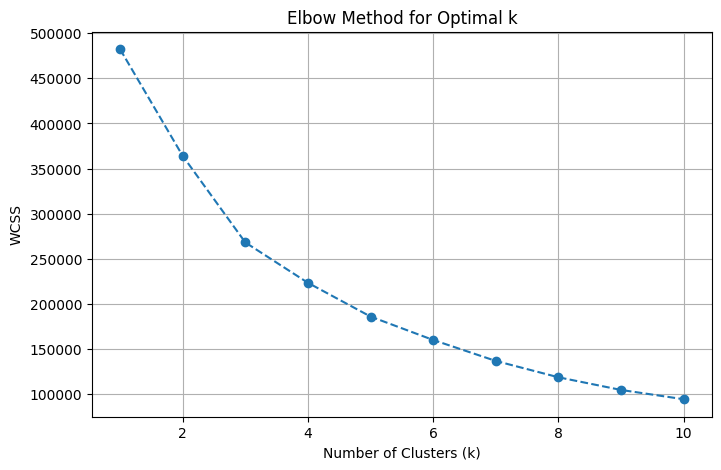

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Pilih hanya fitur hasil scaling
X = agg_data_scaled[features_to_scale]

# Hitung WCSS untuk berbagai nilai k
wcss = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot Elbow
plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()


##Eksekusi dengan K=4

In [ ]:
from sklearn.cluster import KMeans

# Siapkan data yang mau dipakai untuk clustering
X = agg_data_scaled[features_to_scale]

# Eksekusi K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
agg_data_scaled['cluster'] = kmeans.fit_predict(X)

agg_data_scaled['cluster'].value_counts().sort_index()


,count
cluster,
0,83478
1,1080
2,791
3,11106


In [ ]:
agg_data_scaled.groupby('cluster')[features_to_scale].mean().round(2)

,num_orders,num_items,total_spent,avg_spent_per_order,avg_freight_value,num_categories,purchase_span_days,avg_order_interval
cluster,,,,,,,,
0,0.0,-0.05,-0.23,-0.22,-0.23,-0.09,0.0,0.0
1,0.0,0.44,6.53,6.56,2.83,-0.09,0.0,0.0
2,0.0,2.20,0.39,-0.10,-0.03,10.80,0.0,0.0
3,0.0,0.15,1.03,1.04,1.46,-0.09,0.0,0.0


Segmentasi Pelanggan Berdasarkan K-Means Clustering
Cluster 0 – Budget One-Timer
Ciri-ciri utama:
total_spent, avg_spent_per_order, dan freight_value bernilai rendah (nilai z-score negatif)
Aktivitas pembelian sangat minim
Tidak menunjukkan pola loyalitas maupun frekuensi pembelian berulang
Insight Strategis: Merupakan pelanggan baru atau hanya melakukan satu kali transaksi (non-loyal)
Strategi: Dorong retensi dengan welcome voucher, edukasi produk, atau campaign remarketing

Cluster 1 – Seasonal Big Spender
Ciri-ciri utama:
total_spent dan avg_spent_per_order sangat tinggi (z-score > 6)
freight_value tinggi, indikasi pembelian produk besar atau premium
Jumlah kategori produk yang dibeli relatif rendah
Insight Strategis: Karakteristik pelanggan musiman yang aktif bertransaksi saat event/promo
Strategi: Fokus pada kampanye flash sale, promo musiman, dan loyalty program berbasis event

Cluster 2 – Impulsive Trend Hopper
Ciri-ciri utama:
num_items dan num_categories tinggi → banyak produk & kategori yang dijelajahi
total_spent dan avg_spent_per_order justru rendah
Insight Strategis: Pembeli impulsif yang tertarik pada variasi produk, cenderung membeli barang low-price
Strategi: Dorong upselling dan cross-selling, rekomendasi personalisasi berbasis tren

Cluster 3 – Loyal Premium Buyer
Ciri-ciri utama:
total_spent, avg_spent_per_order, dan freight_value cukup tinggi
Jumlah item stabil, mencerminkan perilaku konsisten
Insight Strategis: Pelanggan loyal yang memiliki purchasing power baik dan rutin bertransaksi
Strategi: Prioritaskan customer care, program eksklusif, early access produk baru



In [ ]:
customer_segment = agg_data_scaled[['customer_id', 'cluster']]

##visualisasi

In [ ]:
agg_data_scaled['cluster'] = kmeans.labels_

In [ ]:
# 1. Buat mapping nama segmen berdasarkan cluster
cluster_labels = {
    0: 'Loyal Premium Buyer',
    1: 'Seasonal Big Spender',
    2: 'Budget One-Timer',
    3: 'Impulsive Trend Hopper'
}

# 2. Assign nama segmen ke dataframe utama
agg_data_scaled['segment'] = agg_data_scaled['cluster'].map(cluster_labels)

# 3. Hitung jumlah dan persentase tiap segmen
segment_counts = agg_data_scaled['segment'].value_counts().sort_values(ascending=False)
segment_percentages = (segment_counts / len(agg_data_scaled)) * 100

# 4. Gabungkan nama segmen + jumlah + persen ke satu label
segment_labels_with_counts = [
    f"{segment} ({segment_percentages[segment]:.2f}%)"
    for segment in segment_counts.index
]

# 5. Mapping label lengkap ke nama segmen
segment_label_mapping = {
    segment: f"{segment} ({segment_percentages[segment]:.2f}%)"
    for segment in segment_counts.index
}


In [ ]:
agg_data_scaled.dtypes

,0
customer_id,object
num_orders,float64
num_items,float64
total_spent,float64
avg_spent_per_order,float64
avg_freight_value,float64
num_categories,float64
first_purchase,datetime64[ns]
last_purchase,datetime64[ns]
purchase_span_days,float64


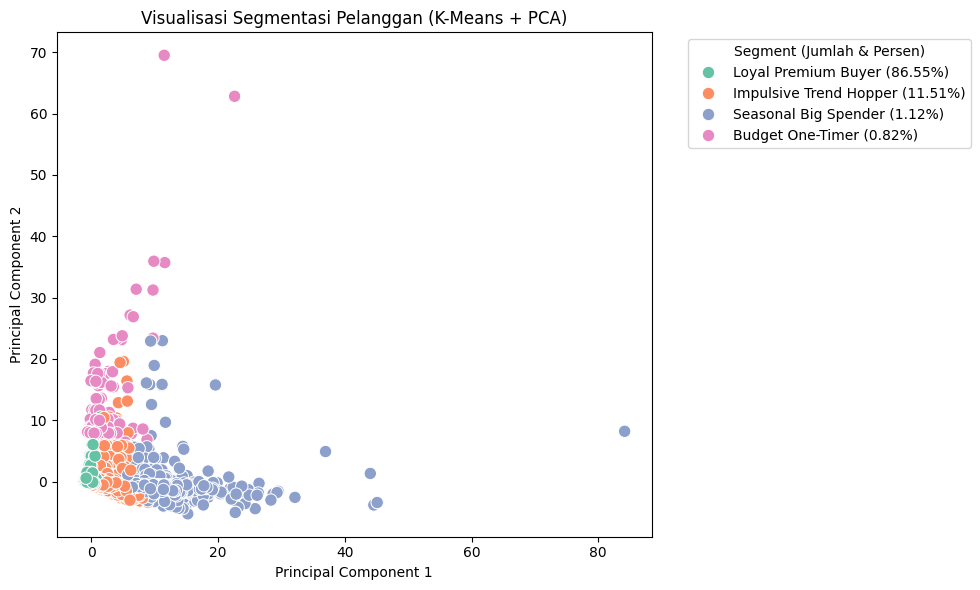

In [ ]:
# Drop kolom non-numerik seperti 'cluster' dan 'segment'
X_pca = agg_data_scaled.drop(columns=['cluster', 'segment'])

# Just in case, keep only numeric columns (anti-error jangka panjang)
X_pca = X_pca.select_dtypes(include='number')

# Jalankan PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_pca)

pca_df = pd.DataFrame()
pca_df['pca1'] = pca_result[:, 0]
pca_df['pca2'] = pca_result[:, 1]
pca_df['segment'] = agg_data_scaled['segment']
pca_df['label_full'] = pca_df['segment'].map(segment_label_mapping)

#Visualisasi PCA + label segmen dengan jumlah & persen
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='pca1', y='pca2', hue='label_full', palette='Set2', s=80)
plt.title('Visualisasi Segmentasi Pelanggan (K-Means + PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Segment (Jumlah & Persen)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
summary_df = pd.DataFrame({
    'Segment': segment_counts.index,
    'Jumlah': segment_counts.values,
    'Persentase': segment_percentages.values
})

summary_df

,Segment,Jumlah,Persentase
0,Loyal Premium Buyer,83478,86.546058
1,Impulsive Trend Hopper,11106,11.514178
2,Seasonal Big Spender,1080,1.119693
3,Budget One-Timer,791,0.820072


In [ ]:
# Hitung jumlah total data untuk setiap cluster
total_counts = segment_counts.sum()

print(f"Total data dari semua cluster: {total_counts}")

Total data dari semua cluster: 96455


# EVALUASI MODELING

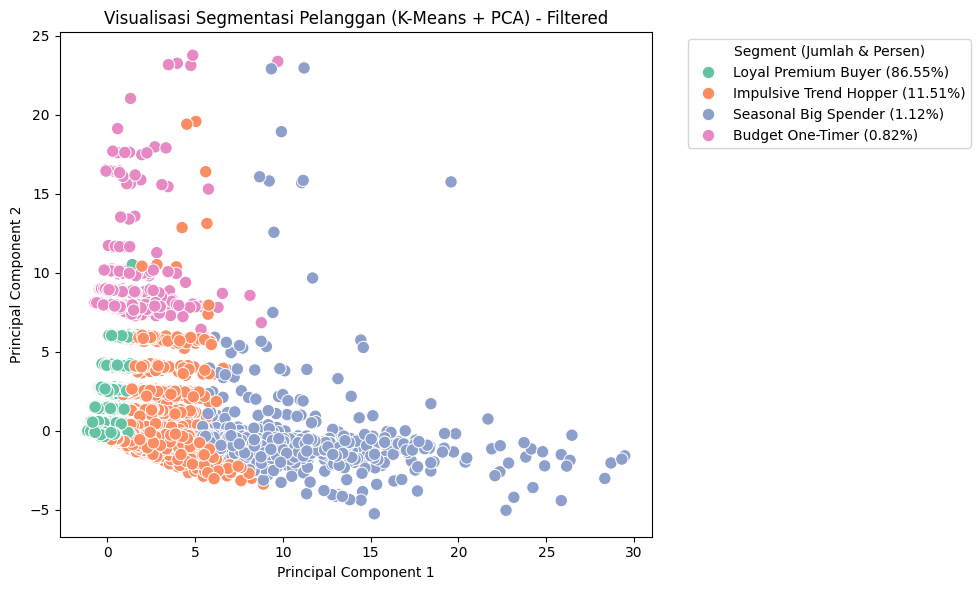

,Segment,Jumlah,Persentase
0,Loyal Premium Buyer,83478,86.560416
1,Impulsive Trend Hopper,11106,11.516088
2,Seasonal Big Spender,1073,1.112620
3,Budget One-Timer,782,0.810875


In [ ]:
# prompt: buatlah untuk menghilangkan outlier principal component 2 dong mungkin bisa sampai nilai 35 dan principal component 1 sampai 40

# Filter outliers based on principal components
pca_df_filtered = pca_df[(pca_df['pca1'] <= 30) & (pca_df['pca2'] <= 25)]

# Visualize the filtered data
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df_filtered, x='pca1', y='pca2', hue='label_full', palette='Set2', s=80)
plt.title('Visualisasi Segmentasi Pelanggan (K-Means + PCA) - Filtered')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Segment (Jumlah & Persen)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Analyze the filtered segments
segment_counts_filtered = pca_df_filtered['segment'].value_counts().sort_values(ascending=False)
segment_percentages_filtered = (segment_counts_filtered / len(pca_df_filtered)) * 100

summary_df_filtered = pd.DataFrame({
    'Segment': segment_counts_filtered.index,
    'Jumlah': segment_counts_filtered.values,
    'Persentase': segment_percentages_filtered.values
})

summary_df_filtered
